# Importing libraries

In [1]:
#Running for the first time?
First_time = 0

In [2]:
#Standard dependencies
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# Tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer , Conv2D , Dense, MaxPooling2D , Input , Flatten
import tensorflow as tf

In [4]:
# Limiting GPU Usage
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu , True)

In [5]:
# Setting-up the Paths

pos_path = os.path.join("data" , "positive")
neg_path = os.path.join("data" , "negative")
anc_path = os.path.join("data" , "anchor")

In [6]:
#Making the directoris
if(First_time):
    os.makedirs(pos_path)
    os.makedirs(neg_path)
    os.makedirs(anc_path)

In [7]:
#Uncompress the dataset
if(First_time):
    !tar -xf lfw.tgz

In [8]:
#Moving all images to the folders that we have created
if First_time:
    for directory in os.listdir('lfw'):
        for file in os.listdir(os.path.join('lfw' , directory)):
            ext_path = os.path.join('lfw' , directory , file)
            new_path = os.path.join(neg_path , file)
            os.replace(ext_path , new_path)

In [9]:
#importing uuid lib for generating unique image names
import uuid

In [10]:
cap = cv2.VideoCapture(0)

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Camera could not be opened")
else:
    print("Camera opened successfully")
    

while cap.isOpened():
    ret , frame = cap.read()
    if not ret:
        print("Error: Cannot read frame from camera")
        break
    frame = frame[120:120+250 , 200:200+250 , :]
    cv2.imshow("Image Collection" , frame)
    
    # if cv2.waitKey(1) & 0XFF == ord('a'):
    #     imgname = os.path.join(anc_path , '{}.jpg'.format(uuid.uuid1()))
    #     cv2.imwrite(imgname , frame)
        
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(pos_path , '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname , frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Camera opened successfully


In the above code, uncomment the lines 

`# if cv2.waitKey(1) & 0XFF == ord('a'):`

`#     imgname = os.path.join(anc_path , '{}.jpg'.format(uuid.uuid1()))`

`#     cv2.imwrite(imgname , frame)` 

to capture anchor images

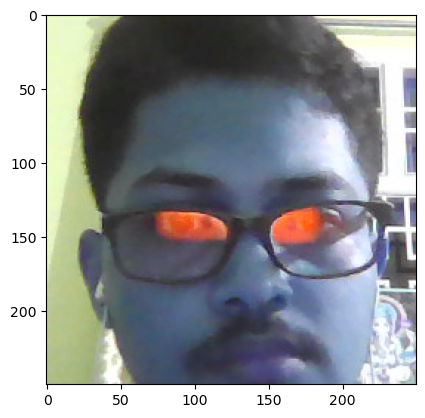

In [11]:
plt.imshow(frame)

In [10]:
anchor = tf.data.Dataset.list_files(anc_path + "\*.jpg").take(300)
positive = tf.data.Dataset.list_files(pos_path + "\*.jpg").take(300)
negative = tf.data.Dataset.list_files(neg_path + "\*.jpg").take(300)

# Preprocessing Image

In [11]:
def preprocess(filepath):
    byte_img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img , (100 , 100))
    img = img / 255.0
    return img

In [12]:
t = anchor.as_numpy_iterator()
t.next()

b'data\\anchor\\c8b1a215-1c13-11ef-bafd-00090faa0001.jpg'

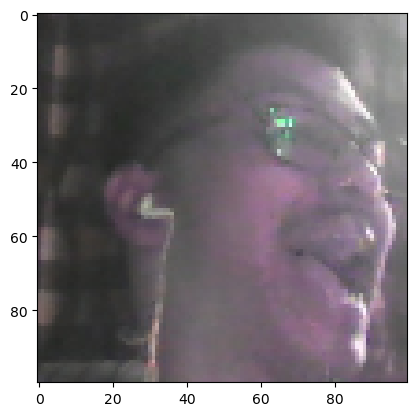

In [13]:
plt.imshow(preprocess("data\\anchor\\cc3c8ec1-1c13-11ef-8217-00090faa0001.jpg"))

# Creating Dataset

In [14]:
positives = tf.data.Dataset.zip((anchor , positive , tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor , negative , tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
t = data.as_numpy_iterator()
res = t.next()
res

(b'data\\anchor\\c33d869c-1c13-11ef-b2b8-00090faa0001.jpg',
 b'data\\positive\\fe5d3f04-1c13-11ef-8eeb-00090faa0001.jpg',
 1.0)

In [16]:
def preprocess_twin(inp_image , val_image , label):
    return (preprocess(inp_image) , preprocess(val_image) , label)

In [17]:
# res
res2 = preprocess_twin(*res)
# plt.imshow(res[0])

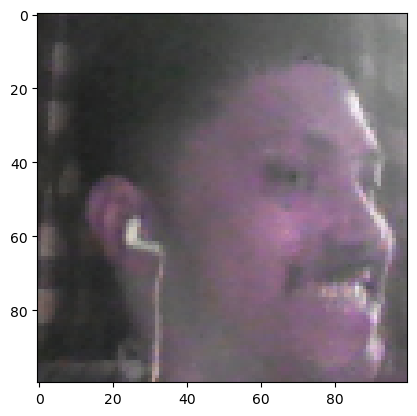

In [18]:
plt.imshow(res2[0])

In [19]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [20]:
samples = data.as_numpy_iterator()
samples.next()

(array([[[0.1627451 , 0.1627451 , 0.1627451 ],
         [0.16887255, 0.16887255, 0.16887255],
         [0.18235295, 0.18235295, 0.18235295],
         ...,
         [0.61764705, 0.6254902 , 0.6137255 ],
         [0.64705884, 0.654902  , 0.6490196 ],
         [0.6509804 , 0.65882355, 0.654902  ]],
 
        [[0.17034313, 0.17818627, 0.1742647 ],
         [0.1742647 , 0.1742647 , 0.1742647 ],
         [0.18014705, 0.18014705, 0.18014705],
         ...,
         [0.61740196, 0.62328434, 0.61446077],
         [0.63529414, 0.64117646, 0.63529414],
         [0.63529414, 0.64117646, 0.6362745 ]],
 
        [[0.17254902, 0.17745098, 0.18235295],
         [0.17132352, 0.1757353 , 0.17352942],
         [0.17941177, 0.17941177, 0.17941177],
         ...,
         [0.6166667 , 0.6166667 , 0.6166667 ],
         [0.6343137 , 0.6343137 , 0.6284314 ],
         [0.64681375, 0.64387256, 0.6360294 ]],
 
        ...,
 
        [[0.2245098 , 0.2245098 , 0.21666667],
         [0.23627451, 0.23627451, 0.23186

In [21]:
#Data Partitioning
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [23]:
#Testing Partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building the Model

In [24]:
def make_embedding():
    inp = Input(shape = (100 , 100 , 3) , name = "input_image")
    
    #First block
    c1 = Conv2D(64 , (10 , 10) , activation = 'relu')(inp)
    m1 = MaxPooling2D(64 , (2 , 2) , padding = 'same')(c1)
    
    #Second block
    c2 = Conv2D(128 , (7 , 7) , activation = 'relu')(m1)
    m2 = MaxPooling2D(64 , (2 , 2) , padding = 'same')(c2)
    
    #Third block
    c3 = Conv2D(128 , (4 , 4) , activation = 'relu')(m2)
    m3 = MaxPooling2D(64 , (2 , 2) , padding = 'same')(c3)
    
    #Fourth Block
    c4 = Conv2D(256 , (4 , 4) , activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096 , activation = 'sigmoid')(f1)
    
    
    return Model(inputs = inp , outputs = d1 , name = 'embedding')

In [25]:
embedding = make_embedding()

In [27]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

# Building Distance Layer

#### Custom Siamese Distance Layer

In [28]:
class L1Dist(Layer):
    def __init__(self , **kwargs):
        super().__init__()
    
    def call(self , inputs):
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)    #Distance

In [29]:
l1 = L1Dist()
l1

<L1Dist name=l1_dist, built=False>

In [30]:
def make_siamese_model():
    #Inputs
    input_image = Input(name = "input_img" , shape = (100 , 100 , 3))
    validation_image = Input(name = "validation_img" , shape = (100 , 100 , 3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image) , embedding(validation_image)])
    
    classifier = Dense(1 , activation = "sigmoid")(distances)
    
    return Model(inputs = [input_image , validation_image] , outputs = classifier , name = "SiameseNetwork")

In [31]:
siamese_model = make_siamese_model()

In [32]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Loss functions and optimizers

In [33]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [34]:
opt = tf.keras.optimizers.Adam(1e-4)

In [35]:
checkpoint_dir = './training_checkpoints'
try:
    os.makedirs(checkpoint_dir)
except:
    pass
checkpoint_prefix = os.path.join(checkpoint_dir , 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt , siamese_model = siamese_model)

# Building training step

In [36]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        Y = batch[2]
        
        yhat = siamese_model(X , training = True)
        loss = binary_cross_loss(Y , yhat)
    print(loss)
    
    #calculate gradients
    grad = tape.gradient(loss , siamese_model.trainable_variables)
    
    #calculate updated weights
    opt.apply_gradients(zip(grad , siamese_model.trainable_variables))
    
    return loss

In [37]:
def train(data , EPOCHS):
    for epoch in range(1 , EPOCHS+1):
        print('\n----Epoch {}/{}'.format(epoch , EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for ind , batch in enumerate(data):
            train_step(batch)
            progbar.update(ind+1)
            
        #Saving checkpoint
        if epoch%10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

# Training the model

In [38]:
EPOCHS = 50

In [40]:
# if First_time:
train(train_data , EPOCHS)


----Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

----Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

----Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

----Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step

----Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

----Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step

----Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step

----Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step

----Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

----Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

----Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

----Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step

----Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

----Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2

# Evaluation

In [41]:
from tensorflow.keras.metrics import Precision , Recall

In [42]:
test_input , test_val , y_true = test_data.as_numpy_iterator().next()

### Predicting

In [43]:
y_hat = siamese_model.predict([test_input , test_val])
print(y_hat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[3.4357126e-07]
 [9.9581632e-09]
 [1.1088938e-08]
 [1.0000000e+00]
 [1.0400097e-04]
 [9.9999547e-01]
 [1.0000000e+00]
 [2.4902951e-07]
 [9.9997032e-01]
 [3.3590825e-07]
 [9.9996918e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9999994e-01]
 [9.9999994e-01]
 [9.9996918e-01]]


In [44]:
print([1 if prediction > 0.5 else 0 for prediction in y_hat])
print(y_true)

[0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]
[0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.]


In [45]:
m = Recall()
m.update_state(y_true , y_hat)
m.result().numpy()

1.0

In [46]:
m = Precision()
m.update_state(y_true , y_hat)
m.result().numpy()

1.0

# Visualize the results

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

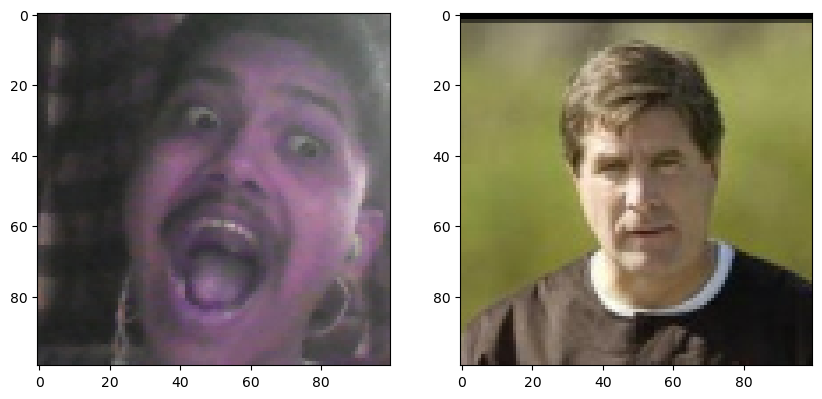

In [47]:
plt.figure(figsize=(10 , 8))
plt.subplot(1 , 2 , 1)
plt.imshow(test_input[1])
plt.subplot(1 , 2 , 2)
plt.imshow(test_val[1])
plt.imshow

# Saving the model

In [48]:
# if First_time:
siamese_model.save("siamesemodel.h5")

In [49]:
# if First_time:
siamese_model.save("siamesemodel.keras")

In [50]:
model = tf.keras.models.load_model("siamesemodel.keras" , 
                                  custom_objects={'L1Dist':L1Dist , 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

In [51]:
model.predict([test_input , test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[3.4357126e-07],
       [9.9581632e-09],
       [1.1088938e-08],
       [1.0000000e+00],
       [1.0400097e-04],
       [9.9999547e-01],
       [1.0000000e+00],
       [2.4902951e-07],
       [9.9997032e-01],
       [3.3590825e-07],
       [9.9996918e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999994e-01],
       [9.9999994e-01],
       [9.9996918e-01]], dtype=float32)

In [52]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Real time verification

In [53]:
try:
    os.makedirs("./application_data")
except:
    pass
try:
    os.makedirs("./application_data/input_images")
except:
    pass
try:
    os.makedirs("./application_data/verification_images")
except:
    pass

In [54]:
import random
import shutil

In [55]:
if First_time:
    l = random.choices(os.listdir("./data/positive/") , k =50)

In [56]:
if First_time:
    for i in l:
        shutil.copy("./data/positive/"+i , "./application_data/verification_images/"+i)

In [57]:
def verify(model , detection_threshold , verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data' , 'verification_images')):
        input_image = preprocess(os.path.join("application_data" , 'input_images' , "input_image.jpg"))
        validation_image = preprocess(os.path.join('application_data' , 'verification_images' , image))
        
        #predicting
        result = model.predict(list(np.expand_dims([input_image , validation_image] , axis=1)))
        results.append(result)
        
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data' , 'verification_images')))
    verified = verification > verification_threshold
    
    return results , verified

# Real Time Prediction using webcam

In [60]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret , frame = cap.read()
    if not ret:
        print("Error: Cannot read frame from camera")
        break
    frame = frame[120:120+250 , 200:200+250 , :]
    cv2.imshow("Image Collection" , frame)
    
    #Verification Trigger
    if cv2.waitKey(10) & 0XFF == ord('v'):
        #save image
        cv2.imwrite(os.path.join('application_data' , 'input_images' , 'input_image.jpg') , frame)
        results , verified = verify(model , 0.5 , 0.5)
        print(verified)

    if cv2.waitKey(10) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

In [61]:
np.sum(np.squeeze(results) > 0.5)

2